In [93]:
import pandas as pd
from pandas import option_context
import numpy as np
import string
import re
import sys
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import spacy
import tomotopy as tp
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
geom_bar, theme, lims, geom_text, position_dodge
from wordcloud import WordCloud
import matplotlib.pyplot as plt

A practical project inspired by https://medium.com/towards-data-science/dont-be-afraid-of-nonparametric-topic-models-d259c237a840

In [94]:
nltk.download('stopwords', quiet=True)
st_words = stopwords.words('english')
st_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [95]:
news = fetch_20newsgroups(subset='train')

In [96]:
news_df = pd.DataFrame([news.target, news.data]).T

news_df.columns = ['target', 'content']

In [97]:
doc_list = news_df.content.values.tolist()

In [98]:
doc_list[3]

'From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It\'s got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek\'s address/phone number?  I\'d like to get some information\nabout this chip.\n\n--\nJoe Green\t\t\t\tHarris Corporation\njgreen@csd.harris.com\t\t\tComputer Systems Division\n"The only thing that really scares me is a person with no sense of humor."\n\t\t\t\t\t\t-- Jonathan Winters\n'

In [99]:
# Remove Special Characters
doc_list = [re.sub(r'\S*@\S*\s?', '', sent) for sent in doc_list]
doc_list = [re.sub(r'\s+', ' ', sent) for sent in doc_list]
doc_list = [re.sub(r"\'", "", sent) for sent in doc_list]

In [100]:
word_list = [gensim.utils.simple_preprocess(txt, deacc=True, min_len=3) for txt in doc_list]

In [101]:
word_list[2][:3]

['from', 'thomas', 'willis']

In [102]:
#bigram to get co-occurrence of the words
bigram = Phrases(word_list, min_count=5, threshold=100)

bigram_model = Phraser(bigram)

In [103]:
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]

In [104]:
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]

In [105]:
word_bigrams[2][:7]

['thomas',
 'willis',
 'questions',
 'organization',
 'purdue_university',
 'engineering',
 'computer']

In [106]:
spC = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
postags = ['NOUN','VERB', 'ADJ', 'ADV'] # Keep nouns, adj, verbs

In [107]:
def lemmatize(word_list, ptags = postags ):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists

In [108]:
word_list_lemmatized = lemmatize(word_bigrams)

In [109]:
with open('t3.txt', 'w') as f:
    for item in word_list_lemmatized:
        f.write("%s" % item)

In [110]:
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [111]:
def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp

In [112]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [113]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=1000)
    hdp.save(''.join(['hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one


Training...


Num docs: 11314 , Vocab size: 17074 , Num words: 1118188
Removed top words: ['line', 'write', 'get', 'organization', 'article', 'say', 'know']
Iteration: 0	Log-likelihood: -7.938360340367178	Num. of topics: 41
Iteration: 100	Log-likelihood: -7.929035867068457	Num. of topics: 44
Iteration: 200	Log-likelihood: -7.923418659461955	Num. of topics: 43
Iteration: 300	Log-likelihood: -7.922834393634171	Num. of topics: 45
Iteration: 400	Log-likelihood: -7.920088480672293	Num. of topics: 44
Iteration: 500	Log-likelihood: -7.91977824949363	Num. of topics: 43
Iteration: 600	Log-likelihood: -7.918715620681232	Num. of topics: 46
Iteration: 700	Log-likelihood: -7.918436931105451	Num. of topics: 46
Iteration: 800	Log-likelihood: -7.917390535263379	Num. of topics: 46
Iteration: 900	Log-likelihood: -7.917336266904346	Num. of topics: 46
Done

Model pmi


Training...


Num docs: 11314 , Vocab size: 17074 , Num words: 1118188
Removed top words: ['line', 'write', 'get', 'organization', 'article', 'say', 'know']
Iteration: 0	Log-likelihood: -8.18537880474112	Num. of topics: 29
Iteration: 100	Log-likelihood: -8.174212951061229	Num. of topics: 30
Iteration: 200	Log-likelihood: -8.171045682487525	Num. of topics: 33
Iteration: 300	Log-likelihood: -8.169165862219987	Num. of topics: 33
Iteration: 400	Log-likelihood: -8.167800503100962	Num. of topics: 33
Iteration: 500	Log-likelihood: -8.166937554043855	Num. of topics: 33
Iteration: 600	Log-likelihood: -8.166142483619897	Num. of topics: 34
Iteration: 700	Log-likelihood: -8.160442788610153	Num. of topics: 34
Iteration: 800	Log-likelihood: -8.153677457173726	Num. of topics: 34
Iteration: 900	Log-likelihood: -8.153023839243676	Num. of topics: 35
Done

Model idf


Training...


Num docs: 11314 , Vocab size: 17074 , Num words: 1118188
Removed top words: ['line', 'write', 'get', 'organization', 'article', 'say', 'know']
Iteration: 0	Log-likelihood: -8.221674097993384	Num. of topics: 27
Iteration: 100	Log-likelihood: -8.214438058459862	Num. of topics: 28
Iteration: 200	Log-likelihood: -8.210713210996389	Num. of topics: 27
Iteration: 300	Log-likelihood: -8.20791401932481	Num. of topics: 29
Iteration: 400	Log-likelihood: -8.206678472596705	Num. of topics: 29
Iteration: 500	Log-likelihood: -8.202078871350423	Num. of topics: 31
Iteration: 600	Log-likelihood: -8.200368204126857	Num. of topics: 31
Iteration: 700	Log-likelihood: -8.200164125450307	Num. of topics: 31
Iteration: 800	Log-likelihood: -8.198453704040222	Num. of topics: 33
Iteration: 900	Log-likelihood: -8.198477119742996	Num. of topics: 32
Done



In [114]:
hdp_one = tp.HDPModel.load("hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("hdp_model_idf.bin")

model_topics =[get_hdp_topics(hdp_one), 
               get_hdp_topics(hdp_pmi), 
               get_hdp_topics(hdp_idf)]

In [115]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)


Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



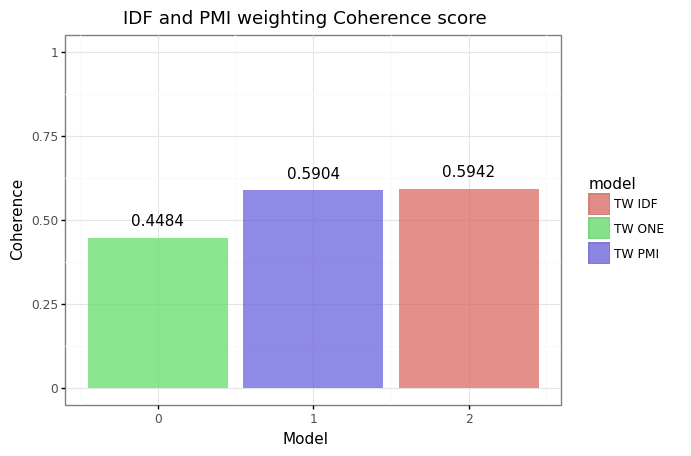

<ggplot: (134268254811)>

In [116]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting Coherence score") 
)

In [117]:
vocab = corpora.Dictionary(word_list_lemmatized)
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

# Build topic list from dictionary
topic_list=[]
for k, tups in hdp_topics.items():
    topic_tokens=[]
    for w, p in tups:
        topic_tokens.append(w)

    topic_list.append(topic_tokens)


In [118]:
cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list_lemmatized, 
                    coherence='c_v')
    
cm.get_coherence()

0.4431107481797254

In [119]:
test_doc = word_list_lemmatized[0]

doc_inst = hdp_idf.make_doc(test_doc)

topic_dist, ll = hdp_idf.infer(doc_inst)

topic_idx = np.array(topic_dist).argmax()
topic_idx

4

In [120]:
hdp_idf.get_topic_words(topic_idx)

[('car', 0.009340386837720871),
 ('bike', 0.005998603533953428),
 ('ride', 0.003542012767866254),
 ('engine', 0.0028575193136930466),
 ('drive', 0.0026731828693300486),
 ('good', 0.002487163757905364),
 ('motorcycle', 0.0023633006494492292),
 ('tire', 0.0022975155152380466),
 ('speed', 0.0022007867228239775),
 ('buy', 0.0021398605313152075)]

In [121]:
def hdp_topics_to_wordclouds(model, topic_dict, save=False):
    '''Wrapper function that generates wordclouds for ALL topics of a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_dic: dict -> per topic, an arrays with top words and associated frequencies
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots
    '''
    
    wcloud = WordCloud(background_color="white")
    fig, ax = plt.subplots(1, 3, figsize=(15,4))

    cnt=0
    for k, arr in topic_dict.items():
        
        create_wordcloud(model, k, fig, ax[cnt], save)
        ax[cnt].title.set_text("Topic # " + str(k))
        cnt+=1
        
        if cnt==3:
            cnt=0
            fig, ax = plt.subplots(1, 3, figsize=(15,4))
    
    
              

def create_wordcloud(model, topic_idx, fig, ax, save=False):
    '''Wrapper function that generates individual wordclouds from topics in a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_idx: int -> topic index
    fig, ax: obj -> pyplot objects from subplots method
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots'''
    wcloud = WordCloud(background_color='white')
    
    topic_freqs = dict(model.get_topic_words(topic_idx))
    
    img = wcloud.generate_from_frequencies(topic_freqs)
    
    ax.imshow(img, interpolation='bilinear')
    ax.axis('off')
    
    if save:
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        img_name = "wcloud_topic_" + str(topic_idx) +'.png'
        plt.savefig(''.join(['imgs/',img_name]), bbox_inches=extent.expanded(1.1, 1.2))
        


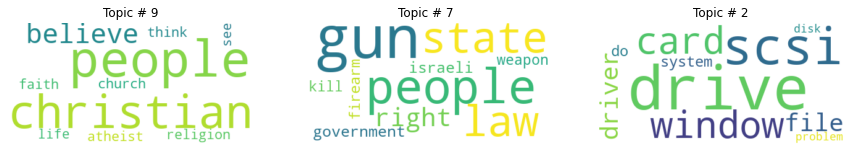

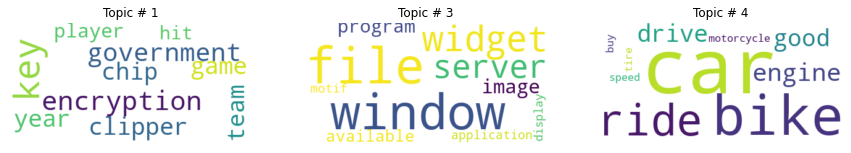

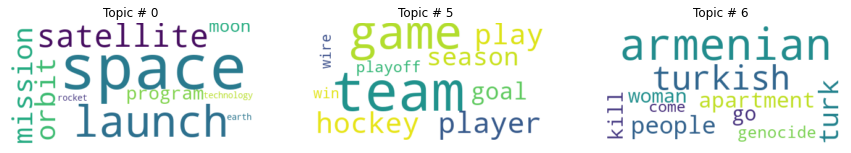

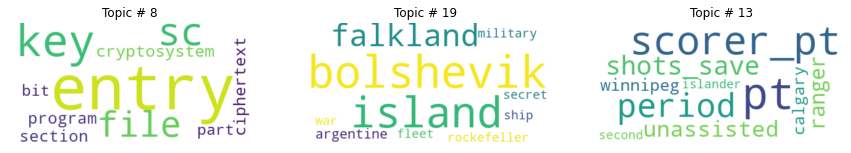

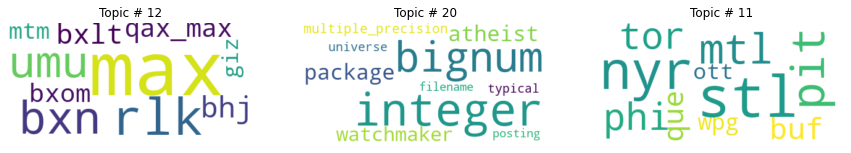

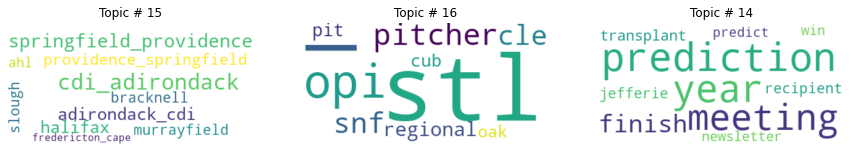

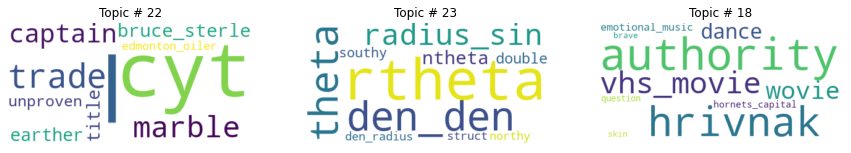

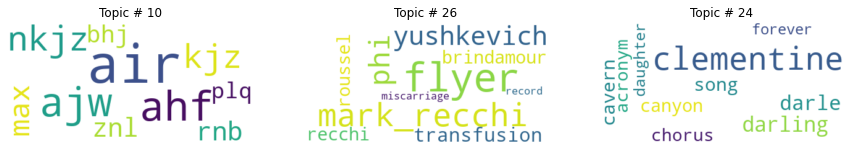

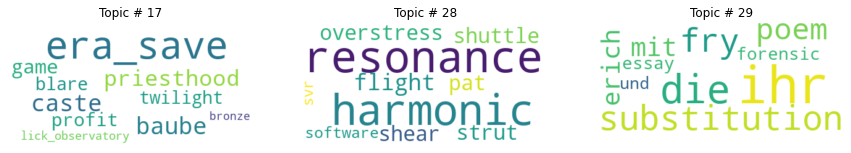

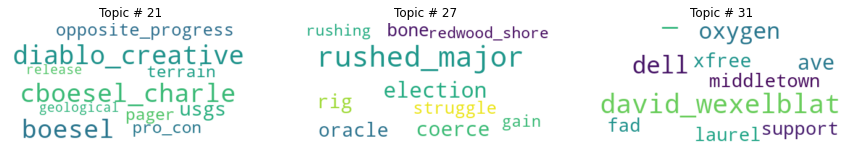

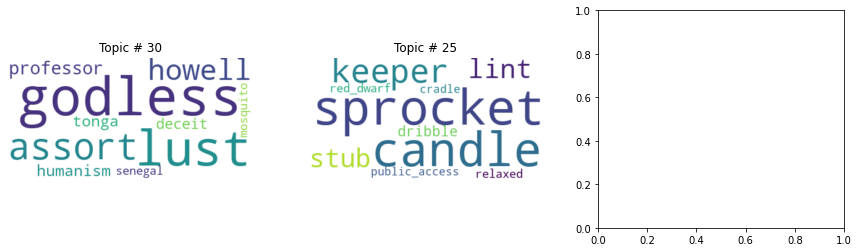

In [122]:
hdp_topics_to_wordclouds(hdp_idf, model_topics[2])